In [1]:
import numpy as np
import pandas as pd

# machine learning
import keras
import ml_edu.experiment
import ml_edu.results

# data visualization
import plotly.express as px

chicago_taxi_dataset = pd.read_csv("chicago_taxi_train.csv")


In [3]:
# Updates dataframe to use specific columns.
training_df = chicago_taxi_dataset.loc[:, ('TRIP_MILES', 'TRIP_SECONDS', 'FARE', 'COMPANY', 'PAYMENT_TYPE', 'TIP_RATE')]

print('Read dataset completed successfully.')
print('Total number of rows: {0}\n\n'.format(len(training_df.index)))

Read dataset completed successfully.
Total number of rows: 31694




In [5]:
training_df.head(200)

print('Total number of rows: {0}\n\n'.format(len(training_df.index)))
training_df.describe(include='all')

Total number of rows: 31694




,TRIP_MILES,TRIP_SECONDS,FARE,COMPANY,PAYMENT_TYPE,TIP_RATE
count,31694.000000,31694.000000,31694.000000,31694,31694,31694.000000
unique,NaN,NaN,NaN,31,7,NaN
top,NaN,NaN,NaN,Flash Cab,Credit Card,NaN
freq,NaN,NaN,NaN,7887,14142,NaN
mean,8.289463,1319.796397,23.905210,NaN,NaN,12.965785
std,7.265672,928.932873,16.970022,NaN,NaN,15.517765
min,0.500000,60.000000,3.250000,NaN,NaN,0.000000
25%,1.720000,548.000000,9.000000,NaN,NaN,0.000000
50%,5.920000,1081.000000,18.750000,NaN,NaN,12.200000
75%,14.500000,1888.000000,38.750000,NaN,NaN,20.800000


In [6]:
#@title Double-click or run to view answers about dataset statistics

answer = '''
What is the maximum fare? 				              Answer: $159.25
What is the mean distance across all trips? 		Answer: 8.2895 miles
How many cab companies are in the dataset? 		  Answer: 31
What is the most frequent payment type? 		    Answer: Credit Card
Are any features missing data? 				          Answer: No
'''

# You should be able to find the answers to the questions about the dataset
# by inspecting the table output after running the DataFrame describe method.
#
# Run this code cell to verify your answers.

# What is the maximum fare?
max_fare = training_df['FARE'].max()
print("What is the maximum fare? 				Answer: ${fare:.2f}".format(fare = max_fare))

# What is the mean distance across all trips?
mean_distance = training_df['TRIP_MILES'].mean()
print("What is the mean distance across all trips? 		Answer: {mean:.4f} miles".format(mean = mean_distance))

# How many cab companies are in the dataset?
num_unique_companies =  training_df['COMPANY'].nunique()
print("How many cab companies are in the dataset? 		Answer: {number}".format(number = num_unique_companies))

# What is the most frequent payment type?
most_freq_payment_type = training_df['PAYMENT_TYPE'].value_counts().idxmax()
print("What is the most frequent payment type? 		Answer: {type}".format(type = most_freq_payment_type))

# Are any features missing data?
missing_values = training_df.isnull().sum().sum()
print("Are any features missing data? 				Answer:", "No" if missing_values == 0 else "Yes")

What is the maximum fare? 				Answer: $159.25
What is the mean distance across all trips? 		Answer: 8.2895 miles
How many cab companies are in the dataset? 		Answer: 31
What is the most frequent payment type? 		Answer: Credit Card
Are any features missing data? 				Answer: No


In [7]:
#@title Code - View correlation matrix
training_df.corr(numeric_only = True)

,TRIP_MILES,TRIP_SECONDS,FARE,TIP_RATE
TRIP_MILES,1.000000,0.800855,0.975344,-0.049594
TRIP_SECONDS,0.800855,1.000000,0.830292,-0.084294
FARE,0.975344,0.830292,1.000000,-0.070979
TIP_RATE,-0.049594,-0.084294,-0.070979,1.000000


In [8]:
#@title Double-click to view answers about the correlation matrix

# Which feature correlates most strongly to the label FARE?
# ---------------------------------------------------------
answer = '''
The feature with the strongest correlation to the FARE is TRIP_MILES.
As you might expect, TRIP_MILES looks like a good feature to start with to train
the model. Also, notice that the feature TRIP_SECONDS has a strong correlation
with fare too.
'''
print(answer)


# Which feature correlates least strongly to the label FARE?
# -----------------------------------------------------------
answer = '''The feature with the weakest correlation to the FARE is TIP_RATE.'''
print(answer)


The feature with the strongest correlation to the FARE is TRIP_MILES.
As you might expect, TRIP_MILES looks like a good feature to start with to train
the model. Also, notice that the feature TRIP_SECONDS has a strong correlation
with fare too.

The feature with the weakest correlation to the FARE is TIP_RATE.


In [9]:
#@title Code - View pairplot
px.scatter_matrix(training_df, dimensions=["FARE", "TRIP_MILES", "TRIP_SECONDS"])

In [10]:
#@title Code - Define ML functions

def create_model(
    settings: ml_edu.experiment.ExperimentSettings,
    metrics: list[keras.metrics.Metric],
) -> keras.Model:
  """Create and compile a simple linear regression model."""
  # Describe the topography of the model.
  # The topography of a simple linear regression model
  # is a single node in a single layer.
  inputs = {name: keras.Input(shape=(1,), name=name) for name in settings.input_features}
  concatenated_inputs = keras.layers.Concatenate()(list(inputs.values()))
  outputs = keras.layers.Dense(units=1)(concatenated_inputs)
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compile the model topography into code that Keras can efficiently
  # execute. Configure training to minimize the model's mean squared error.
  model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=settings.learning_rate),
                loss="mean_squared_error",
                metrics=metrics)

  return model


def train_model(
    experiment_name: str,
    model: keras.Model,
    dataset: pd.DataFrame,
    label_name: str,
    settings: ml_edu.experiment.ExperimentSettings,
) -> ml_edu.experiment.Experiment:
  """Train the model by feeding it data."""

  # Feed the model the feature and the label.
  # The model will train for the specified number of epochs.
  features = {name: dataset[name].values for name in settings.input_features}
  label = dataset[label_name].values
  history = model.fit(x=features,
                      y=label,
                      batch_size=settings.batch_size,
                      epochs=settings.number_epochs)

  return ml_edu.experiment.Experiment(
      name=experiment_name,
      settings=settings,
      model=model,
      epochs=history.epoch,
      metrics_history=pd.DataFrame(history.history),
  )

print("SUCCESS: defining linear regression functions complete.")

SUCCESS: defining linear regression functions complete.


Epoch 1/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 406.1242 - rmse: 20.1525
Epoch 2/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 173.7493 - rmse: 13.1814
Epoch 3/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 47.8078 - rmse: 6.9143
Epoch 4/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 17.7441 - rmse: 4.2124
Epoch 5/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 16.3239 - rmse: 4.0403
Epoch 6/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 15.4046 - rmse: 3.9249
Epoch 7/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 14.7722 - rmse: 3.8435
Epoch 8/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 14.3914 - rmse: 3.7936
Epoch 9/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 14.1921 - rmse: 3.7672
Epoch 10/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 14.0986 - rmse: 3.7548
Epoch 11/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 14.0633 - rmse: 3.7501
Epoch 12/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 14.0460 - rmse: 3.74

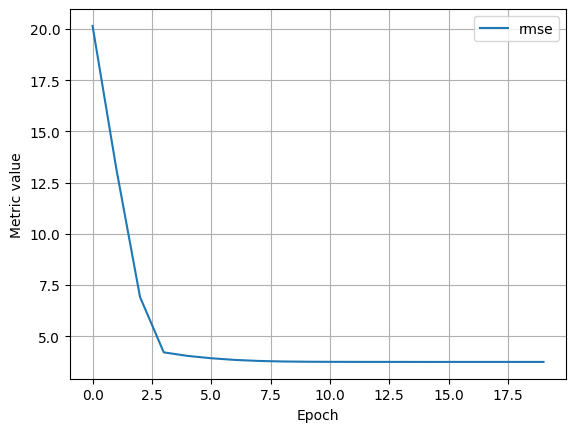

In [11]:
#@title Code - Experiment 1

# The following variables are the hyperparameters.
settings_1 = ml_edu.experiment.ExperimentSettings(
    learning_rate = 0.001,
    number_epochs = 20,
    batch_size = 50,
    input_features = ['TRIP_MILES']
)

metrics = [keras.metrics.RootMeanSquaredError(name='rmse')]

model_1 = create_model(settings_1, metrics)

experiment_1 = train_model('one_feature', model_1, training_df, 'FARE', settings_1)

ml_edu.results.plot_experiment_metrics(experiment_1, ['rmse'])
ml_edu.results.plot_model_predictions(experiment_1, training_df, 'FARE')

In [13]:
#@title Double-click to view answers for training model with one feature

# How many epochs did it take to converge on the final model?
# -----------------------------------------------------------------------------
answer = """
Use the loss curve to see where the loss begins to level off during training.

With this set of hyperparameters:

  learning_rate = 0.001
  epochs = 20
  batch_size = 50

it takes about 5 epochs for the training run to converge to the final model.
"""
print(answer)

# How well does the model fit the sample data?
# -----------------------------------------------------------------------------
answer = '''
It appears from the model plot that the model fits the sample data fairly well.
'''
print(answer)


Use the loss curve to see where the loss begins to level off during training.

With this set of hyperparameters:

  learning_rate = 1
  epochs = 20
  batch_size = 50

it takes about 5 epochs for the training run to converge to the final model.


It appears from the model plot that the model fits the sample data fairly well.



Epoch 1/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2053.1824 - rmse: 45.3121
Epoch 2/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1987.7543 - rmse: 44.5842
Epoch 3/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1923.0657 - rmse: 43.8528
Epoch 4/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1859.5786 - rmse: 43.1228
Epoch 5/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1797.4742 - rmse: 42.3966
Epoch 6/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1735.9733 - rmse: 41.6650
Epoch 7/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1675.6831 - rmse: 40.9351
Epoch 8/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1616.6085 - rmse: 40.2071
Epoch 9/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1558.8085 - rmse: 39.4818
Epoch 10/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1501.6211 - rmse: 38.7508
Epoch 11/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1445.5981 - rmse: 38.0210
Epoch 12/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

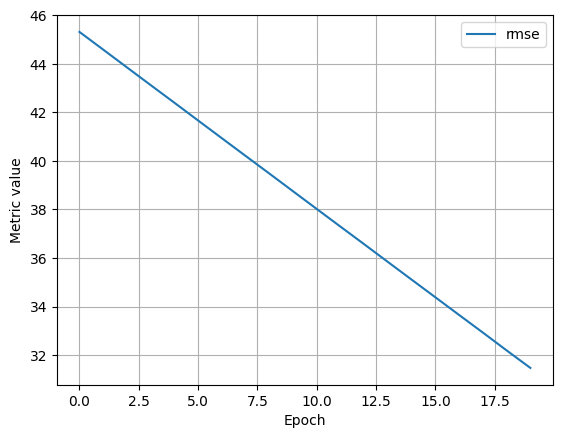

In [16]:
#@title Code - Experiment 1

# The following variables are the hyperparameters.
settings_1 = ml_edu.experiment.ExperimentSettings(
    learning_rate = 0.0001,
    number_epochs = 20,
    batch_size = 50,
    input_features = ['TRIP_MILES']
)

metrics = [keras.metrics.RootMeanSquaredError(name='rmse')]

model_1 = create_model(settings_1, metrics)

experiment_1 = train_model('one_feature', model_1, training_df, 'FARE', settings_1)

ml_edu.results.plot_experiment_metrics(experiment_1, ['rmse'])
ml_edu.results.plot_model_predictions(experiment_1, training_df, 'FARE')

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 833.8156 - rmse: 28.8759
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 790.9490 - rmse: 28.1238
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 749.7967 - rmse: 27.3824
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 709.8120 - rmse: 26.6423
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 670.7968 - rmse: 25.8997
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 632.9839 - rmse: 25.1592
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 596.4105 - rmse: 24.4215
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 560.7621 - rmse: 23.6804
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 526.3987 - rmse: 22.9434
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 493.1129 - rmse: 22.2061
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 460.9570 - rmse: 21.4699
Epoch 12/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 429.8643 - rmse: 20.7332
E

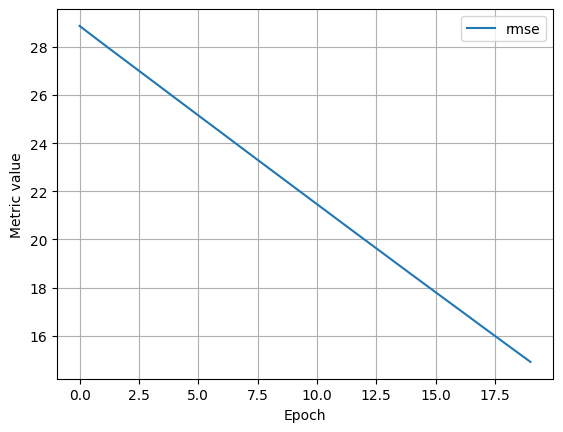

In [17]:
#@title Code - Experiment 1

# The following variables are the hyperparameters.
settings_1 = ml_edu.experiment.ExperimentSettings(
    learning_rate = 0.001,
    number_epochs = 20,
    batch_size = 500,
    input_features = ['TRIP_MILES']
)

metrics = [keras.metrics.RootMeanSquaredError(name='rmse')]

model_1 = create_model(settings_1, metrics)

experiment_1 = train_model('one_feature', model_1, training_df, 'FARE', settings_1)

ml_edu.results.plot_experiment_metrics(experiment_1, ['rmse'])
ml_edu.results.plot_model_predictions(experiment_1, training_df, 'FARE')

In [19]:
#@title Double-click to view answers for hyperparameter experiments

# How did raising the learning rate impact your ability to train the model?
# -----------------------------------------------------------------------------
answer = """
When the learning rate is too high, the loss curve bounces around and does not
appear to be moving towards convergence with each iteration. Also, notice that
the predicted model does not fit the data very well. With a learning rate that
is too high, it is unlikely that you will be able to train a model with good
results.
"""
print(answer)

# How did lowering the learning rate impact your ability to train the model?
# -----------------------------------------------------------------------------
answer = '''
When the learning rate is too small, it may take longer for the loss curve to
converge. With a small learning rate the loss curve decreases slowly, but does
not show a dramatic drop or leveling off. With a small learning rate you could
increase the number of epochs so that your model will eventually converge, but
it will take longer.
'''
print(answer)

# Did changing the batch size effect your training results?
# -----------------------------------------------------------------------------
answer = '''
Increasing the batch size makes each epoch run faster, but as with the smaller
learning rate, the model does not converge with just 20 epochs. If you have
time, try increasing the number of epochs and eventually you should see the
model converge.
'''
print(answer)


When the learning rate is too high, the loss curve bounces around and does not
appear to be moving towards convergence with each iteration. Also, notice that
the predicted model does not fit the data very well. With a learning rate that
is too high, it is unlikely that you will be able to train a model with good
results.


When the learning rate is too small, it may take longer for the loss curve to
converge. With a small learning rate the loss curve decreases slowly, but does
not show a dramatic drop or leveling off. With a small learning rate you could
increase the number of epochs so that your model will eventually converge, but
it will take longer.


Increasing the batch size makes each epoch run faster, but as with the smaller
learning rate, the model does not converge with just 20 epochs. If you have
time, try increasing the number of epochs and eventually you should see the
model converge.



Epoch 1/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 83.9686 - rmse: 9.1634
Epoch 2/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 52.7656 - rmse: 7.2640
Epoch 3/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 32.2771 - rmse: 5.6813
Epoch 4/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 20.1761 - rmse: 4.4918
Epoch 5/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 14.8743 - rmse: 3.8567
Epoch 6/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 13.2668 - rmse: 3.6424
Epoch 7/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 12.6843 - rmse: 3.5615
Epoch 8/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 12.3929 - rmse: 3.5204
Epoch 9/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 12.2328 - rmse: 3.4975
Epoch 10/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 12.1511 - rmse: 3.4858
Epoch 11/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 12.1273 - rmse: 3.4824
Epoch 12/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 12.1102 - rmse: 3.4800
E

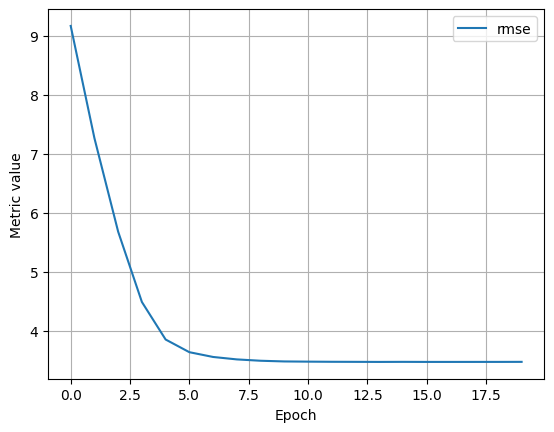

In [20]:
#@title Code - Experiment 3

# The following variables are the hyperparameters.
settings_3 = ml_edu.experiment.ExperimentSettings(
    learning_rate = 0.001,
    number_epochs = 20,
    batch_size = 50,
    input_features = ['TRIP_MILES', 'TRIP_MINUTES']
)

training_df['TRIP_MINUTES'] = training_df['TRIP_SECONDS']/60

metrics = [keras.metrics.RootMeanSquaredError(name='rmse')]

model_3 = create_model(settings_3, metrics)

experiment_3 = train_model('two_features', model_3, training_df, 'FARE', settings_3)

ml_edu.results.plot_experiment_metrics(experiment_3, ['rmse'])
ml_edu.results.plot_model_predictions(experiment_3, training_df, 'FARE')

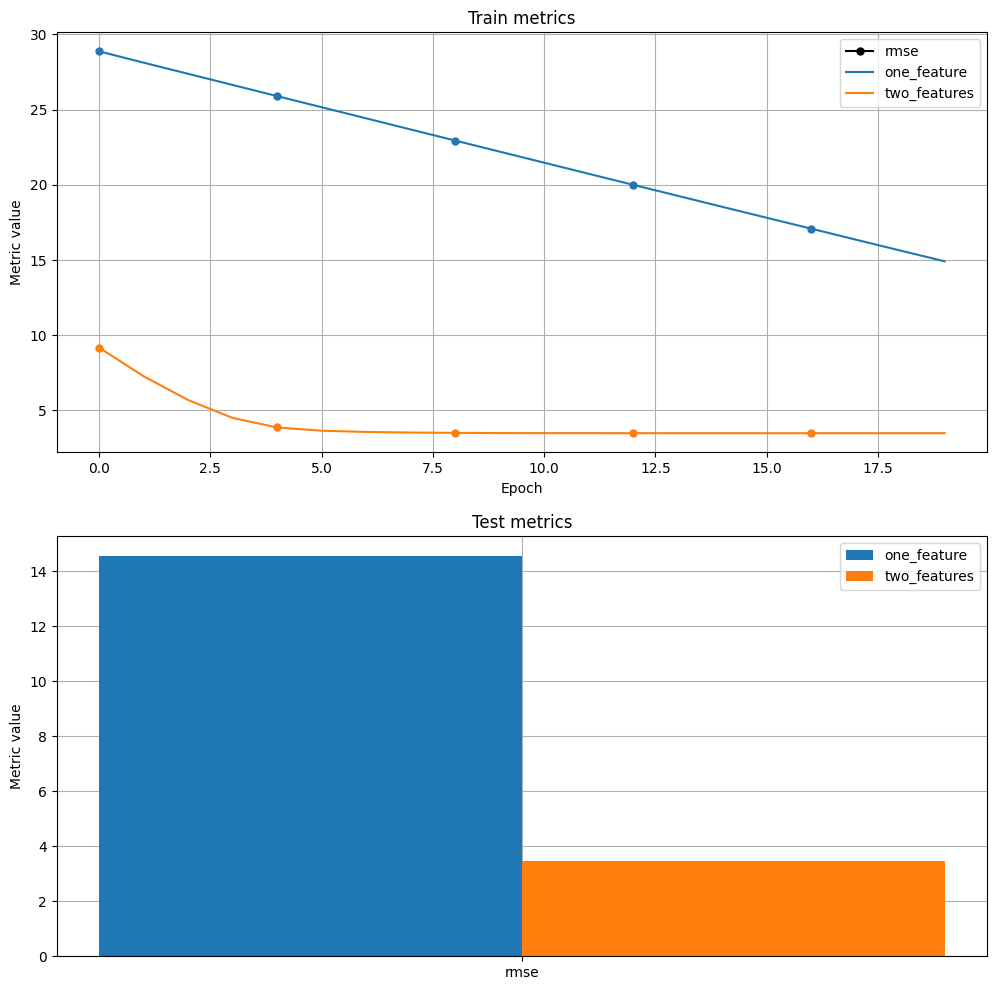

In [21]:
ml_edu.results.compare_experiment([experiment_1, experiment_3], ['rmse'], training_df, training_df['FARE'].values)

In [22]:
#@title Code - Define functions to make predictions
def format_currency(x):
  return "${:.2f}".format(x)

def build_batch(df, batch_size):
  batch = df.sample(n=batch_size).copy()
  batch.set_index(np.arange(batch_size), inplace=True)
  return batch

def predict_fare(model, df, features, label, batch_size=50):
  batch = build_batch(df, batch_size)
  predicted_values = model.predict_on_batch(x={name: batch[name].values for name in features})

  data = {"PREDICTED_FARE": [], "OBSERVED_FARE": [], "L1_LOSS": [],
          features[0]: [], features[1]: []}
  for i in range(batch_size):
    predicted = predicted_values[i][0]
    observed = batch.at[i, label]
    data["PREDICTED_FARE"].append(format_currency(predicted))
    data["OBSERVED_FARE"].append(format_currency(observed))
    data["L1_LOSS"].append(format_currency(abs(observed - predicted)))
    data[features[0]].append(batch.at[i, features[0]])
    data[features[1]].append("{:.2f}".format(batch.at[i, features[1]]))

  output_df = pd.DataFrame(data)
  return output_df

def show_predictions(output):
  header = "-" * 80
  banner = header + "\n" + "|" + "PREDICTIONS".center(78) + "|" + "\n" + header
  print(banner)
  print(output)
  return

In [23]:
#@title Code - Make predictions

output = predict_fare(experiment_3.model, training_df, experiment_3.settings.input_features, 'FARE')
show_predictions(output)

--------------------------------------------------------------------------------
|                                 PREDICTIONS                                  |
--------------------------------------------------------------------------------
   PREDICTED_FARE OBSERVED_FARE L1_LOSS  TRIP_MILES TRIP_MINUTES
0           $6.10         $6.00   $0.10        0.60         7.00
1           $6.16         $5.75   $0.41        0.70         6.00
2          $21.79        $21.10   $0.69        6.97        25.37
3          $46.07        $43.00   $3.07       16.60        57.00
4          $41.62        $42.00   $0.38       16.60        27.00
5          $35.39        $35.75   $0.36       13.81        23.27
6          $54.70        $56.75   $2.05       18.80        85.00
7          $11.54        $11.25   $0.29        3.00        10.77
8          $35.85        $34.75   $1.10       12.35        46.42
9           $8.09         $9.00   $0.91        1.44         8.87
10         $44.54        $44.25   $0.29   

In [24]:
#@title Double-click to view answers for validate model

# How close is the predicted value to the label value?
# -----------------------------------------------------------------------------
answer = '''
Based on a random sampling of examples, the model seems to do pretty well
predicting the fare for a taxi ride. Most of the predicted values do not vary
significantly from the observed value. You should be able to see this by looking
at the column L1_LOSS = |observed - predicted|.
'''
print(answer)


Based on a random sampling of examples, the model seems to do pretty well
predicting the fare for a taxi ride. Most of the predicted values do not vary
significantly from the observed value. You should be able to see this by looking
at the column L1_LOSS = |observed - predicted|.

